# Supervised Learning

In diesem Notebook werden die in der entsprechenden Vorlesung vorgestellten Algorithmen detailliert am Fallbeispiel [Iris-Datensatz](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data): Erkennen des Typs der Iris-Pflanze anhand von Eigenschaften. Der Iris-Datensatz ist so beliebt, weil er quasi schlüsselfertig ist. Es ist (kaum) Data Engineering notwendig.

Wir werden uns folgende Algorithmen ansehen:
* Lineare Regression
* Logistische Regression
* Naive Bayes
* Decision Tree
* Support Vector Machine
* Random Forest
* Adaboost
* XGBoost


## Datenaufbereitung

Wir laden die Datei mit den Irisdaten in ein Pandas-Dataframe und müssen kleine Sachen anpassen....das war's dann aber mit dem Data Engineering. Auch ist der Datensatz nicht sehr groß.

1. Länge Kelchblatt in cm (sepal length)
2. Breite Kelchblatt in cm (sepal width)
3. Länge Blütenblatt in cm (petal length)
4. Breite Blütenblatt in cm (petal width)
5. Die zu erkennende Klasse der Iris (class: 
  * Iris Setosa
  * Iris Versicolour
  * Iris Virginica

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Standard-Library für das Plotten von Graphen.
import seaborn as sns
from matplotlib.colors import ListedColormap

# Trennzeichen Komma, keine Überschrift in der ersten Zeile der Datei, und die Bezeichnung der Spalten s.o.
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

df_iris = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", 
                      sep=',', # einzelnen Einträge per , getrennt
                      header=None,  # keine Überschrift
                      names=col_names, # wir haben eigene Überschriften
                      dtype={'sepal_length': 'float32', 
                             'sepal_width': 'float32', 
                             'petal_length': 'float32',
                             'petal_width': 'float32', 
                             'class': 'category'} # wir machen jetzt gleich die Datentypenumwandlung
                      )
print(df_iris)

     sepal_length  sepal_width  petal_length  petal_width           class
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]


Der Datensatz hat 150 Zeilen mit 4 Features und class als Zielwert. Den Zielwert in der Spalte class müssen wir noch umwandeln. Also schauen wir ihn uns an

In [3]:
print(df_iris['class'].unique()) # drucke eindeutige Werte für Spalte class

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Categories (3, object): ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


Machine Learning Algorithmen können für Zielwerte nur mit Zahlen arbeiten. Deshalb weisen wir den 3 verschiedenen Werten jeweils 1 Ziffer zu.

In [4]:
class_mapping = {"Iris-setosa": 1,
                 "Iris-versicolor": 2, 
                 "Iris-virginica": 3, 
                 "UNDEFINED": 0}
                 
df_iris['Target']= df_iris['class'].map(class_mapping)
df_iris['Target'] = df_iris['Target'].astype('int')
df_iris = df_iris.drop(['class'], axis=1)
df_iris.dtypes

sepal_length    float32
sepal_width     float32
petal_length    float32
petal_width     float32
Target            int64
dtype: object

Wir sehen im Unterschied zu den vorigen Datentypen der Spalten, daß Target jetzt auch eine Nummer (statt wie vorher Text) ist.

In [5]:
df_iris.describe(include='all')

,sepal_length,sepal_width,petal_length,petal_width,Target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843335,3.054000,3.758667,1.198667,2.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,1.000000
25%,5.100000,2.800000,1.600000,0.300000,1.000000
50%,5.800000,3.000000,4.350000,1.300000,2.000000
75%,6.400000,3.300000,5.100000,1.800000,3.000000
max,7.900000,4.400000,6.900000,2.500000,3.000000


Wir sehen daß wir für die 150 Zeilen in jeder Spalte Werte haben, also keine fehlenden Werte haben

In [6]:
y = df_iris['Target'] # Konvention ist dass y immer die Ziel-Variable ist, die wir vorhersagen wollen
X = df_iris.iloc[:, :-1]  # verkürzte Schreibweise: alle Zeilen (der Doppelpunkt vor dem Komma) und zu den Zeilen die jeweiligen Spalten bis hin zur vorletzten werden in X gespeichert.

# letzter Test. 
print("X hat folgenden Shape", X.shape) # X sollte 150 Zeilen mit jeweils 4 Spalten/ Features haben
print("y-Vektor hat folgenden Shape", y.shape) #Y sollte 150 Zeilen mit 1 Wert, der Zielvariablen haben

X hat folgenden Shape (150, 4)
y-Vektor hat folgenden Shape (150,)


Jetzt noch die Daten in eine Trainings- und Testmenge einteilen (Validierungsmenge macht nicht so viel Sinn bei nur 150 Einträgen....).

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Test ob Aufteilung funktioniert hat.
print("Shapes von X_train und X_test", X_train.shape, X_test.shape)
print("Shapes von y_train und y_test", y_train.shape, y_test.shape)

Shapes von X_train und X_test (105, 4) (45, 4)
Shapes von y_train und y_test (105,) (45,)


Wir wollen auch die Ergebnisse visualisieren. Das Dataset hat 4 Features; 4-dimensionale Darstellungen sind aber nicht so einfach möglich.

Zur Vereinfachung bauen wir zusätzlich ein reduziertes Datenset mit nur 2 Features und können so ein kartesisches Koordinatensystem verwenden.

Für die 2 Features nehmen wir Petal_width und Petal_length also Blütenblattbreite und -länge. 
Der Grund ist, daß dies die beiden wichtigsten Features sind (wie wir später im Abschnitt Random Frest und XGBoost sehen werden....).

In [8]:
y_reduced_dataset = y
X_reduced_dataset = df_iris.iloc[:, :-1]

X_reduced_dataset = X_reduced_dataset.drop('petal_length', axis=1)
X_reduced_dataset = X_reduced_dataset.drop('petal_width', axis=1)

print(X_reduced_dataset)

     sepal_length  sepal_width
0             5.1          3.5
1             4.9          3.0
2             4.7          3.2
3             4.6          3.1
4             5.0          3.6
..            ...          ...
145           6.7          3.0
146           6.3          2.5
147           6.5          3.0
148           6.2          3.4
149           5.9          3.0

[150 rows x 2 columns]


Das wars mit der Datenaufbereitung. Jetzt gehts mit Machine Learning los!

## Machine Learning

### Hilfsfunktionen

#### Modellgüte-Kriterien auswerten

In [9]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

def Model_accuracy(predicted_y_values, real_y_values):
  print(confusion_matrix(real_y_values, predicted_y_values)) #Confusion Matrix
  print(classification_report(real_y_values, predicted_y_values)) # Print summary report
  print('accuracy is ',accuracy_score(predicted_y_values, real_y_values)) # Print accuracy score

#### Modell visualisieren

In [10]:
# Source Code entnommen aus: https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
def visualize_Model_with2D_Graph(Reduced_dataset, Classifier, AlgorithmName):
  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  x_min, x_max = Reduced_dataset.iloc[:, 0].min() - .5, Reduced_dataset.iloc[:, 0].max() + .5
  y_min, y_max = Reduced_dataset.iloc[:, 1].min() - .5, Reduced_dataset.iloc[:, 1].max() + .5
  h = .02  # step size in the mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = Classifier.predict(np.c_[xx.ravel(), yy.ravel()])

  cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

  # Plot also the training points
  sns.scatterplot(Reduced_dataset.iloc[:, 0], Reduced_dataset.iloc[:, 1], hue=y, cmap=cmap_light, s=100, palette={1:'orange', 2:'cyan', 3:'cornflowerblue'})

  plt.xlabel('Sepal length')
  plt.ylabel('Sepal width')

  plt.title(AlgorithmName)
  plt.legend()

  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.xticks(())
  plt.yticks(())

  plt.show()

### "Einfache" Verfahren

##### Logistische Regression

In [11]:
from sklearn.linear_model import LogisticRegression # importiere die Bibliothek für logistische Regression

logmodel = LogisticRegression() # keine spezifischen Parameter angegeben, d.h. nur Standardwerte

logmodel.fit(X_train, y_train) # trainiere das Modell auf den Trainingsdaten
y_pred_logistic_regression = logmodel.predict(X_test) # und sage vorher....das wars schon!!

In [12]:
Model_accuracy(y_pred_logistic_regression, y_test)

[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.94      0.97        18
           3       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

accuracy is  0.9777777777777777


Text(0, 0.5, 'sepal_width')

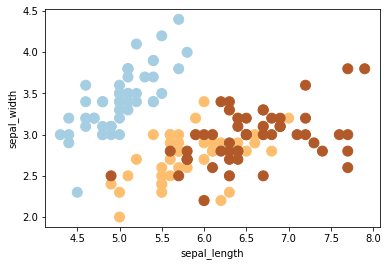

In [13]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Paired, s=100)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

Wir führen jetzt die log. Regression auf den verkleinerten Datensatz aus.

[[50  0  0]
 [ 0 37 13]
 [ 0 14 36]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       0.73      0.74      0.73        50
           3       0.73      0.72      0.73        50

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150

accuracy is  0.82


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


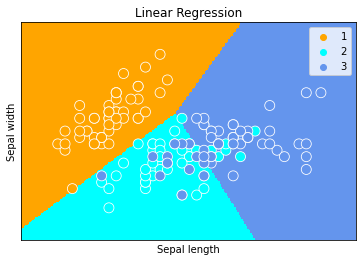

In [14]:
logreg = LogisticRegression()
logreg.fit(X_reduced_dataset, y_reduced_dataset)
Z_log = logreg.predict(X_reduced_dataset)

Model_accuracy(Z_log, y_reduced_dataset)

visualize_Model_with2D_Graph(X_reduced_dataset, logreg, "Linear Regression")

##### Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred_naive_Bayes = gnb.predict(X_test)

In [16]:
Model_accuracy(y_pred_naive_Bayes, y_test)

[[16  0  0]
 [ 0 18  0]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        11

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

accuracy is  1.0


[[49  1  0]
 [ 0 37 13]
 [ 0 19 31]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        50
           2       0.65      0.74      0.69        50
           3       0.70      0.62      0.66        50

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150

accuracy is  0.78


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


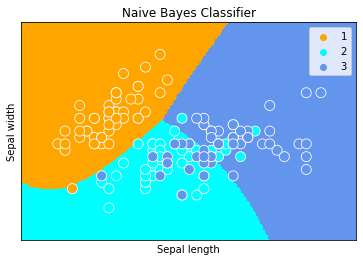

In [17]:
gnb_reduced = GaussianNB()
gnb_reduced.fit(X_reduced_dataset, y_reduced_dataset)
Z_gnb = gnb_reduced.predict(X_reduced_dataset)

Model_accuracy(Z_gnb, y_reduced_dataset)

visualize_Model_with2D_Graph(X_reduced_dataset, gnb_reduced, "Naive Bayes Classifier")

##### K Nearest Neighbours

In [18]:
from sklearn import neighbors

n_neighbors = 5

knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
y_pred_KNN = knn.predict(X_test)

In [19]:
Model_accuracy(y_pred_KNN, y_test)

[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.94      0.97        18
           3       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

accuracy is  0.9777777777777777


[[49  1  0]
 [ 0 39 11]
 [ 0 10 40]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        50
           2       0.78      0.78      0.78        50
           3       0.78      0.80      0.79        50

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150

accuracy is  0.8533333333333334


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


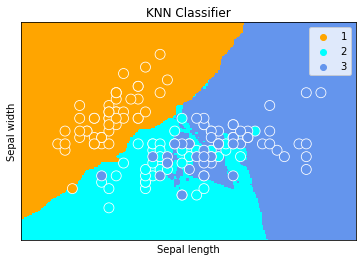

In [20]:
knn_reduced = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_reduced.fit(X_reduced_dataset, y_reduced_dataset)
Z_knn_reduced = knn_reduced.predict(X_reduced_dataset)

Model_accuracy(Z_knn_reduced, y_reduced_dataset)

visualize_Model_with2D_Graph(X_reduced_dataset, knn_reduced, "KNN Classifier")

##### Entscheidungsbaum/ Decision Trees

In [21]:
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier()

decisionTree.fit(X_train, y_train)
y_pred_DecTree = decisionTree.predict(X_test)

In [22]:
Model_accuracy(y_pred_DecTree, y_test)

[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.94      0.97        18
           3       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

accuracy is  0.9777777777777777


Wenn wir schon einen Entscheidungsbaum verwenden, dann wollen wir uns auch die Ergebnisse so anzeigen lassen

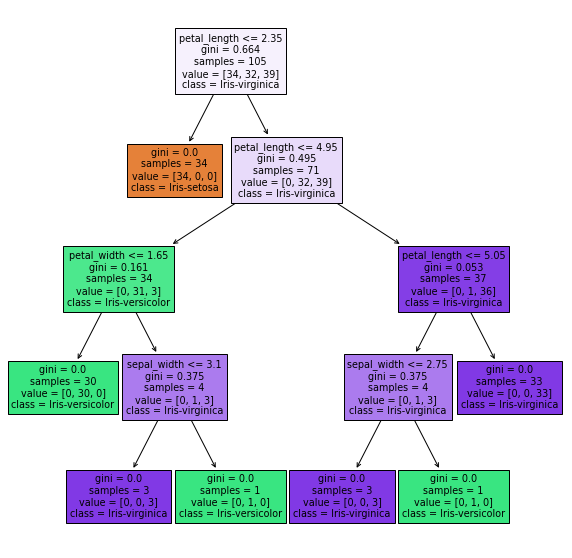

In [23]:
from sklearn import tree
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(decisionTree, 
                   feature_names= ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],  
                   class_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"],
                   filled=True)

[[50  0  0]
 [ 0 49  1]
 [ 0 10 40]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       0.83      0.98      0.90        50
           3       0.98      0.80      0.88        50

    accuracy                           0.93       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.94      0.93      0.93       150

accuracy is  0.9266666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


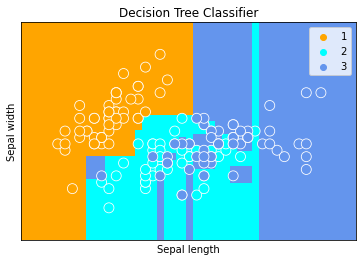

In [24]:
decisionTree_reduced = DecisionTreeClassifier()
decisionTree_reduced.fit(X_reduced_dataset, y_reduced_dataset)
Z_DT_reduced = decisionTree_reduced.predict(X_reduced_dataset)

Model_accuracy(Z_DT_reduced, y_reduced_dataset)

visualize_Model_with2D_Graph(X_reduced_dataset, decisionTree_reduced, "Decision Tree Classifier")

##### Support Vector Machine

In [25]:
from sklearn import svm

SVC_basis = svm.SVC()
SVC_basis.fit(X_train, y_train)
y_pred_SVM_basis = SVC_basis.predict(X_test)

In [26]:
Model_accuracy(y_pred_SVM_basis, y_test)

[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.94      0.97        18
           3       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

accuracy is  0.9777777777777777


[[50  0  0]
 [ 0 38 12]
 [ 0 15 35]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       0.72      0.76      0.74        50
           3       0.74      0.70      0.72        50

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150

accuracy is  0.82


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


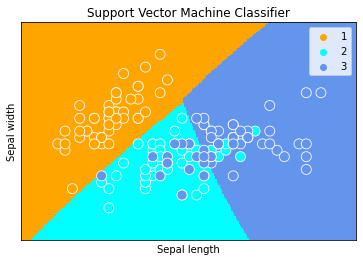

In [27]:
SVC_basis_reduced = svm.SVC()
SVC_basis_reduced.fit(X_reduced_dataset, y_reduced_dataset)
Z_SVM_reduced = SVC_basis_reduced.predict(X_reduced_dataset)

Model_accuracy(Z_SVM_reduced, y_reduced_dataset)

visualize_Model_with2D_Graph(X_reduced_dataset, SVC_basis_reduced, "Support Vector Machine Classifier")

### Kombinierte Verfahren

##### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

RandomForest_clf = RandomForestClassifier()
RandomForest_clf.fit(X_train, y_train)

y_pred_RandomForest = RandomForest_clf.predict(X_test)

In [29]:
Model_accuracy(y_pred_RandomForest, y_test)

[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.94      0.97        18
           3       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

accuracy is  0.9777777777777777


Random Forest hat ein spannendes Feature und zwar die Feature-Importance. Das heißt, es gibt eine Gewichtung an, welches Feature welchen gewichteten Beitrag für das Label erreicht.

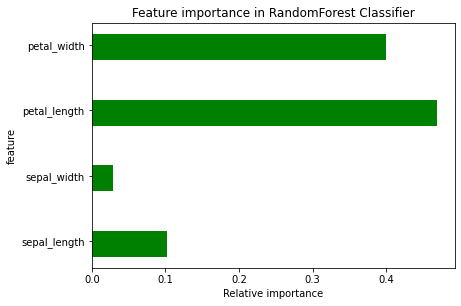

<Figure size 360x360 with 0 Axes>

In [30]:
y_FI = RandomForest_clf.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y_FI)) # the x locations for the groups
ax.barh(ind, y_FI, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col_names, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

Wir sehen, daß Petal_length (ca. 45%) und Petal_width (ca. 40%) die beiden mit Abstand wichtigsten Features sind. 

In [31]:
import numpy as np

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(RandomForest_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head()

,importance
feature,
petal_length,0.469
petal_width,0.400
sepal_length,0.102
sepal_width,0.029


In [32]:
from sklearn.tree import export_graphviz
import pydot
# Extract the small tree
tree_small = RandomForest_clf.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

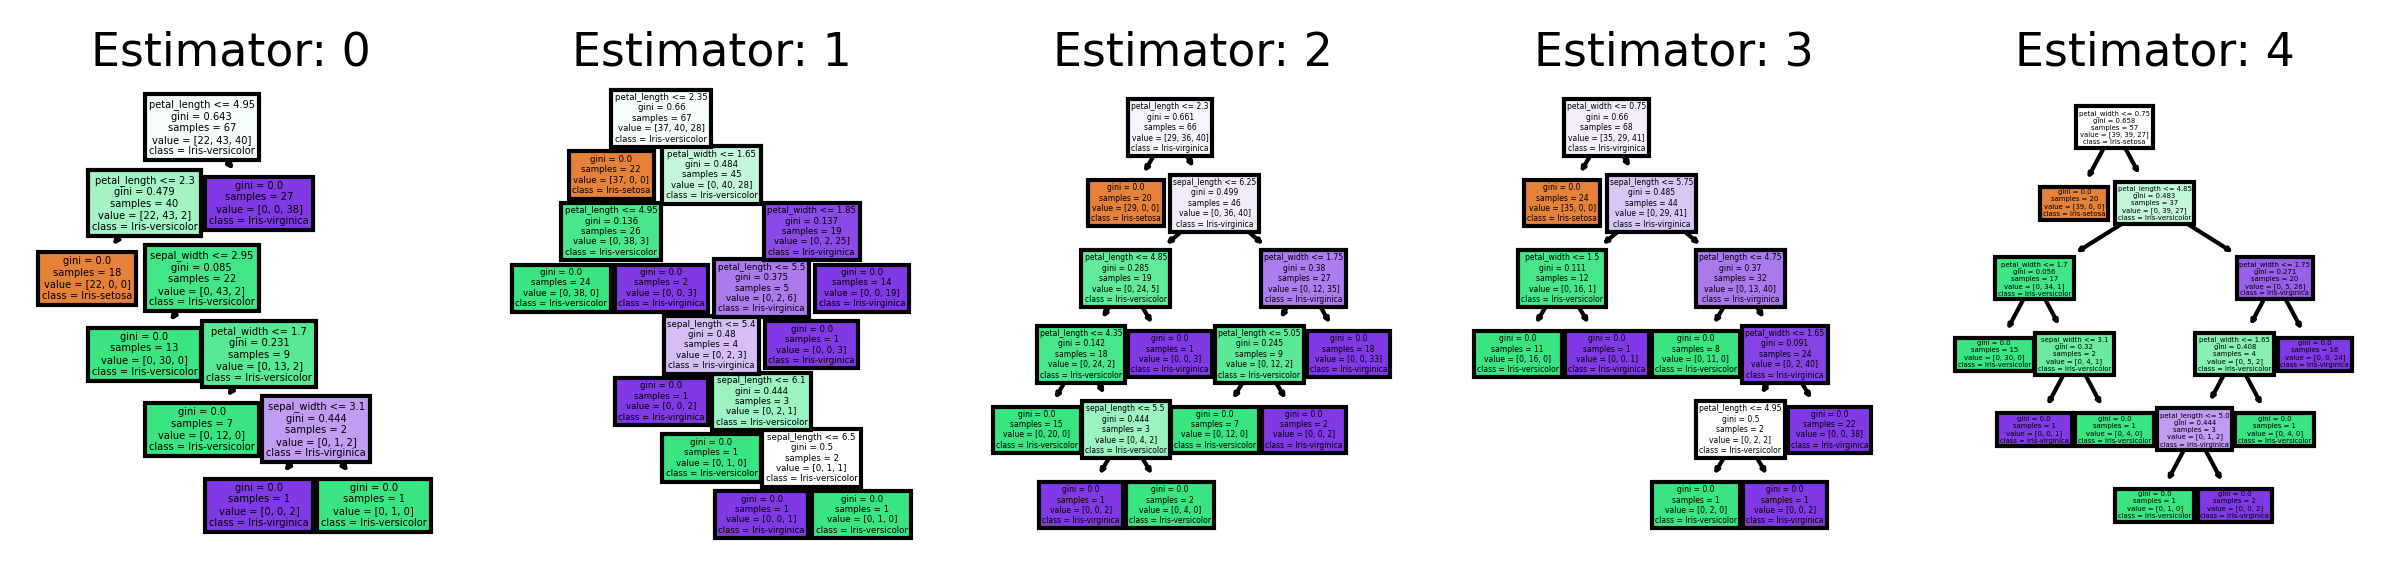

In [33]:
# Source code taken from https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=300)
for index in range(0, 5):
    tree.plot_tree(RandomForest_clf.estimators_[index],
                   feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 
                   class_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"],
                   filled = True,
                   ax = axes[index]);
    
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

[[50  0  0]
 [ 0 43  7]
 [ 0  4 46]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       0.91      0.86      0.89        50
           3       0.87      0.92      0.89        50

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150

accuracy is  0.9266666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


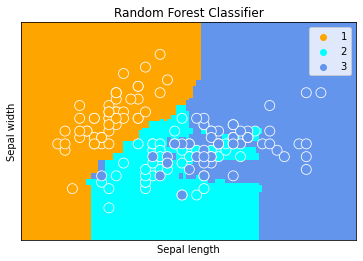

In [34]:
RandomForest_clf_reduced = RandomForestClassifier()
RandomForest_clf_reduced.fit(X_reduced_dataset, y_reduced_dataset)
Z_RF_reduced = RandomForest_clf_reduced.predict(X_reduced_dataset)

Model_accuracy(Z_RF_reduced, y_reduced_dataset)

visualize_Model_with2D_Graph(X_reduced_dataset, RandomForest_clf_reduced, "Random Forest Classifier")

##### AdaBoost

In [35]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost_clf = AdaBoostClassifier()
adaBoost_clf.fit(X_train, y_train)

y_pred_AdaBoost = adaBoost_clf.predict(X_test)

In [36]:
Model_accuracy(y_pred_AdaBoost, y_test)

[[16  0  0]
 [ 0 17  1]
 [ 0  3  8]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       0.85      0.94      0.89        18
           3       0.89      0.73      0.80        11

    accuracy                           0.91        45
   macro avg       0.91      0.89      0.90        45
weighted avg       0.91      0.91      0.91        45

accuracy is  0.9111111111111111


##### XGBoost

In [37]:
import xgboost as xgb

XGB_clf = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
XGB_clf.fit(X_train, y_train)

y_pred_XGBT = XGB_clf.predict(X_test)

In [38]:
Model_accuracy(y_pred_XGBT, y_test)

[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      0.94      0.97        18
           3       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

accuracy is  0.9777777777777777


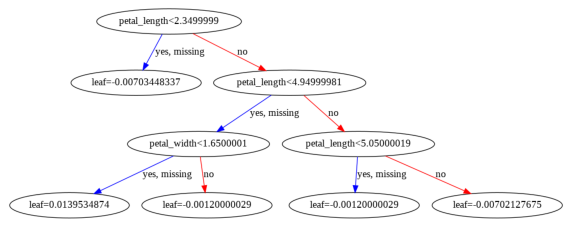

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_tree(XGB_clf, num_trees=1, ax=ax)
plt.show()

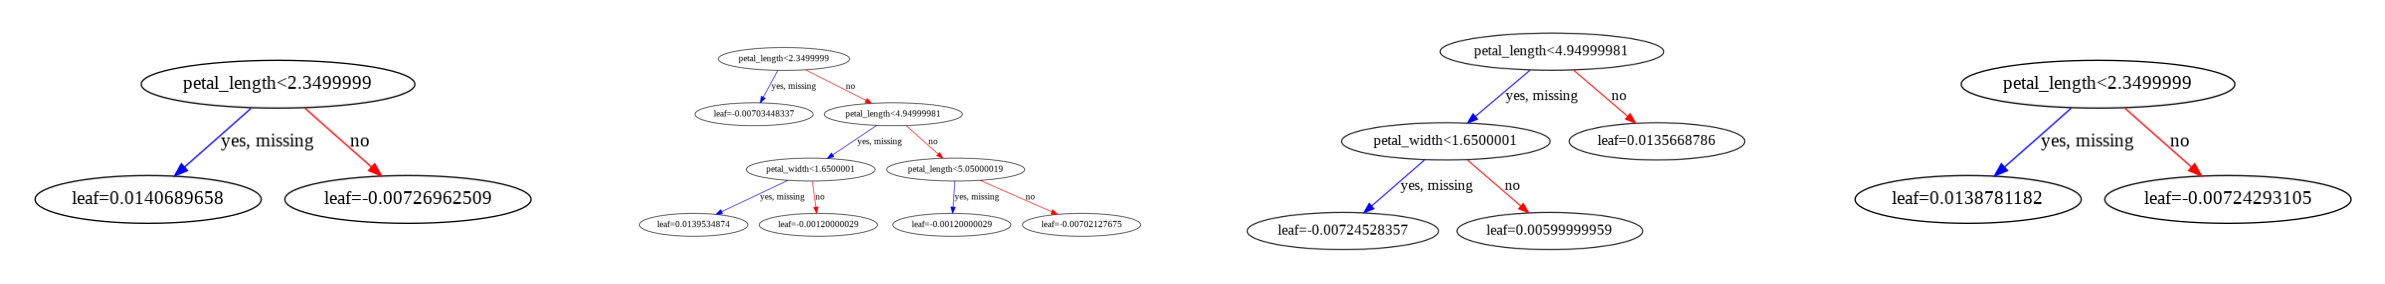

In [40]:
fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = (10,5), dpi=300)
for index in range(0, 4):
  xgb.plot_tree(XGB_clf, num_trees=index, ax=axes[index])

plt.show()

In [41]:
XGB_clf_reduced = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
XGB_clf_reduced.fit(X_reduced_dataset, y_reduced_dataset)
Z_XGB_reduced = XGB_clf_reduced.predict(X_reduced_dataset)

Model_accuracy(Z_XGB_reduced, y_reduced_dataset)

[[50  0  0]
 [ 1 35 14]
 [ 0 12 38]]
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        50
           2       0.74      0.70      0.72        50
           3       0.73      0.76      0.75        50

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150

accuracy is  0.82


### Zusammenfassung

Man sieht, daß die Ergebnisse bei den meisten Verfahren recht gleich sind. Das liegt aber auch daran, daß es sich hier um ein recht kleines und einfaches Datenset handelt. 

Es ging auch mehr darum, aufzuzeigen, daß die meisten relevanten Algorithmen über SKLearn recht einfach verwendet werden können.